## Entropy for Auto Exposure

Entropy can be a useful metric in image processing as it quantifies the amount of information or complexity in an image. The equation:

$
E = -\sum_{g} p(g) \cdot \log_{2}(p(g))
$

Where:
- $E$ is the entropy
- $p(g)$ is the probability of each gray level $g$ in the image
- The summation runs over all gray levels present in the image
- The base of the logarithm is 2 because the entropy is measured in bits

Given the Sky360 all-sky camera will be guiding a secondary pan tilt focus camera, the frames aquired from the all-sky should ideally be optimal in the sense of providing maximum information, and neither be over or under exposed. The proposal put forward here is to use entropy to push auto-exposure target brightness settings towards those that deliver higher entropy, where possible. 

First, some imports and functions for calculating entropy and brightness:

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def calc_entropy(img):
    histogram = cv2.calcHist([img], [0], None, [256], [0,256])
    histogram /= histogram.sum()  
    entropy = -np.sum(histogram*np.log2(histogram + np.finfo(float).eps))
    return entropy / 8

def calc_brightness(img):
    return np.mean(img) / 255.0

Claude Shannon, the father of information theory, defined entropy as a measure of the uncertainty or randomness in a set of data. We can examine that idea by looking at the range of entropy through the following two images. 

The first image is uniform consisting of all white pixels. This has an entropy of zero which is basically saying it contains no information. The second is noisy with random pixel intensities over the 8-bit range (0-255). This gives a high entropy and close to the highest possible value of one (normalised). Indeed the maximum entropy would occur when all 256 possible intensity values are equally likely.

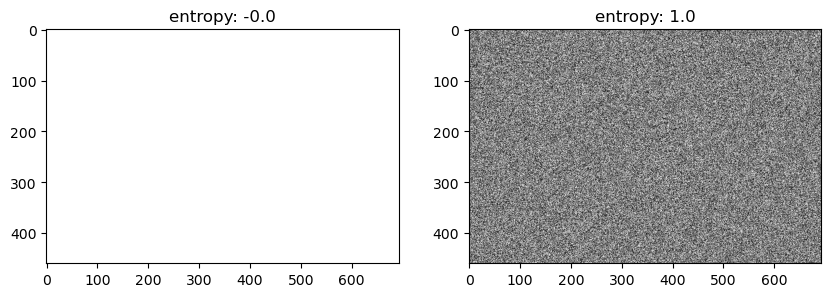

In [11]:
a = (np.ones((460, 693))*255).astype('uint8')
b = (np.random.random((460, 693))*256).astype('uint8')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(a, cmap='gray', vmin=0, vmax=255)
plt.title('entropy: ' + str(round(calc_entropy(a), 3)))
plt.subplot(1,2,2)
plt.imshow(b, cmap='gray', vmin=0, vmax=255)
plt.title('entropy: ' + str(round(calc_entropy(b), 3)))
plt.show()

Lets now look at an actual frame from a QHY camera and it's associated entropy (0.802). For interest, the right plot shows the same image but with pixels from the image randomly shuffled. This shuffled image has the same information content so we get the same entropy.

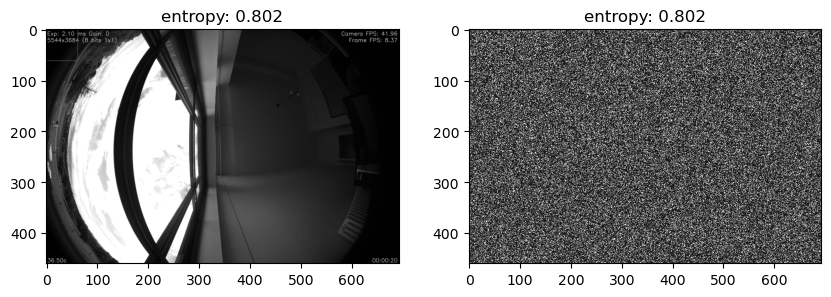

In [12]:
img = cv2.imread('images/ss_2600.000000_20230705140551.png', cv2.IMREAD_GRAYSCALE)
img_shuf = img.copy().flatten()
np.random.shuffle(img_shuf)
img_shuf = img_shuf.reshape(img.shape)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('entropy: ' + str(round(abs(calc_entropy(img)), 3)))
plt.subplot(1,2,2)
plt.imshow(img_shuf, cmap='gray', vmin=0, vmax=255)
plt.title('entropy: ' + str(round(calc_entropy(img_shuf), 3)))
plt.show()

Now lets look entropy recorded over 10 frames as exposure is adjusted from a lower value to a higher value in 1 ms steps.

Initially when exposure is low the resulting (normalised) brightness and entropy values are low. Then, as we might expect, when exposure increases brightness increases. However, entropy has a non-linear relationship with exposure. As exposure increases entropy increases but then decreases as the image becomes over-exposed causing loss in information.

One idea is to try and guide the auto exposure algorithm towards this max peak for entropy by making smart adjustments to exposure and gain. In the example below, the optimum target brightness for the AE to obtain max entropy would be in the region of 0.5 (see image 4 below where an entropy of 0.84 is reached).

However, the relationship between entropy and exposure isn't straightforward! The target value for entropy should ideally be the value that corresponds to this peak but it's difficult to predict this value in advance since it can change based on the scene content and lighting conditions. 

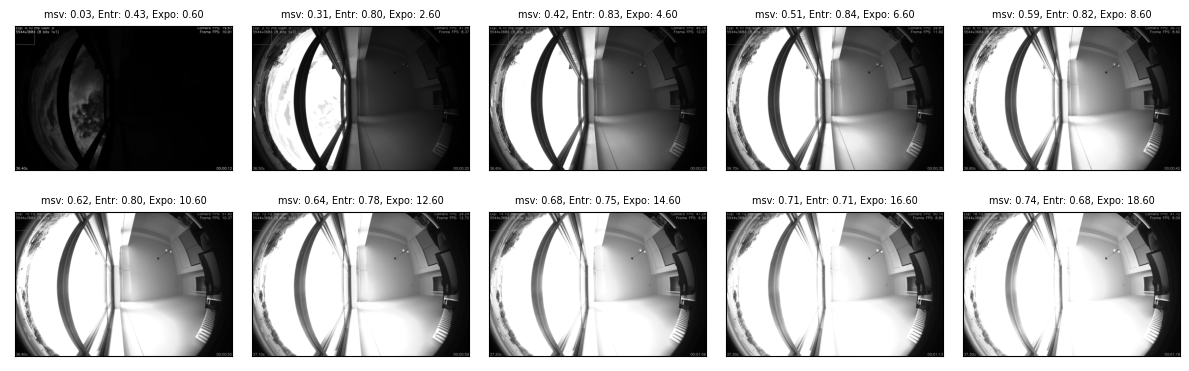

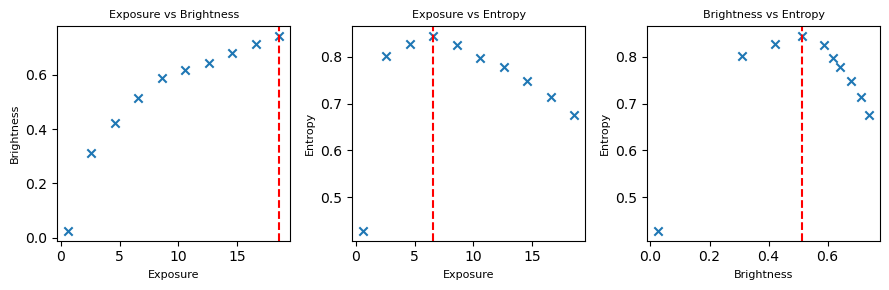

In [18]:
import os

directory = "images"
files = os.listdir(directory)
exclude_files = {'no_gain.png', 'high_gain.png'}
files = [file for file in files if file.endswith('.png') and file not in exclude_files]


def get_sort_key(file_name):
    number = file_name.split('_')[1]
    return float(number)

files.sort(key=get_sort_key)

exposure_values = []
brightness_values = []
entropy_values = []

fig, axs = plt.subplots(2, 5, figsize=(12, 4))

for i, ax in enumerate(axs.flat):
    img = cv2.imread(os.path.join(directory, files[i]), cv2.IMREAD_GRAYSCALE)
    
    img_brightness = calc_brightness(img)
    brightness_values.append(img_brightness)
    img_entropy = calc_entropy(img)
    entropy_values.append(img_entropy)
    exposure = float(files[i].split('_')[1]) / 1000
    exposure_values.append(exposure)
    
    ax.imshow(img, cmap='gray')
    ax.set_title('msv: {:.2f}, Entr: {:.2f}, Expo: {:.2f}'.format(img_brightness, img_entropy, exposure), fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axs.flat:
    ax.label_outer()

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# Scatter plot for Exposure vs Brightness
axs[0].scatter(exposure_values, brightness_values, marker='x')
max_brightness_index = np.argmax(brightness_values)
axs[0].axvline(exposure_values[max_brightness_index], color='r', linestyle='--')  # Draw a vertical line at max brightness
axs[0].set_xlabel('Exposure', fontsize=8)
axs[0].set_ylabel('Brightness', fontsize=8)
axs[0].set_title('Exposure vs Brightness', fontsize=8)

# Scatter plot for Exposure vs Entropy
axs[1].scatter(exposure_values, entropy_values, marker='x')
max_entropy_index = np.argmax(entropy_values)
axs[1].axvline(exposure_values[max_entropy_index], color='r', linestyle='--')  # Draw a vertical line at max entropy
axs[1].set_xlabel('Exposure', fontsize=8)
axs[1].set_ylabel('Entropy', fontsize=8)
axs[1].set_title('Exposure vs Entropy', fontsize=8)

# Scatter plot for Brightness vs Entropy
axs[2].scatter(brightness_values, entropy_values, marker='x')
axs[2].axvline(brightness_values[max_entropy_index], color='r', linestyle='--')  # Draw a vertical line at max entropy
axs[2].set_xlabel('Brightness', fontsize=8)
axs[2].set_ylabel('Entropy', fontsize=8)
axs[2].set_title('Brightness vs Entropy', fontsize=8)

plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()


### Conclusions

Entropy may be a useful metric for guiding the sky360 all-sky camera auto exposure to maximise information content of frames. 

Some implementation considerations: 

- We may be able to use a cascaded PID controller design where the outer PID examines frame entropy and then sets the target brightness of the inner PID to maximise entropy. However this is complex given the non-linear aspect highlighted above.

- Another approach could be to use a single PID but take advantage of the oscillatory nature of this type of controller. The PID could be tuned to oscillate enough to allow exploration for exposure settings that yield higher entropy.

- Another approach found in the literature uses Bayesian Optimisation - https://rpm.snu.ac.kr/publications/jwkim-2018-icra.pdf

Note that entropy guidance may be a bad idea in low light / night conditions given a noisy image will have higher entropy (see example below where the right image uses gain to increase brightness to the equivalent level of the left image but subsequently has more noise). As such when gain comes into play we could toggle this off.

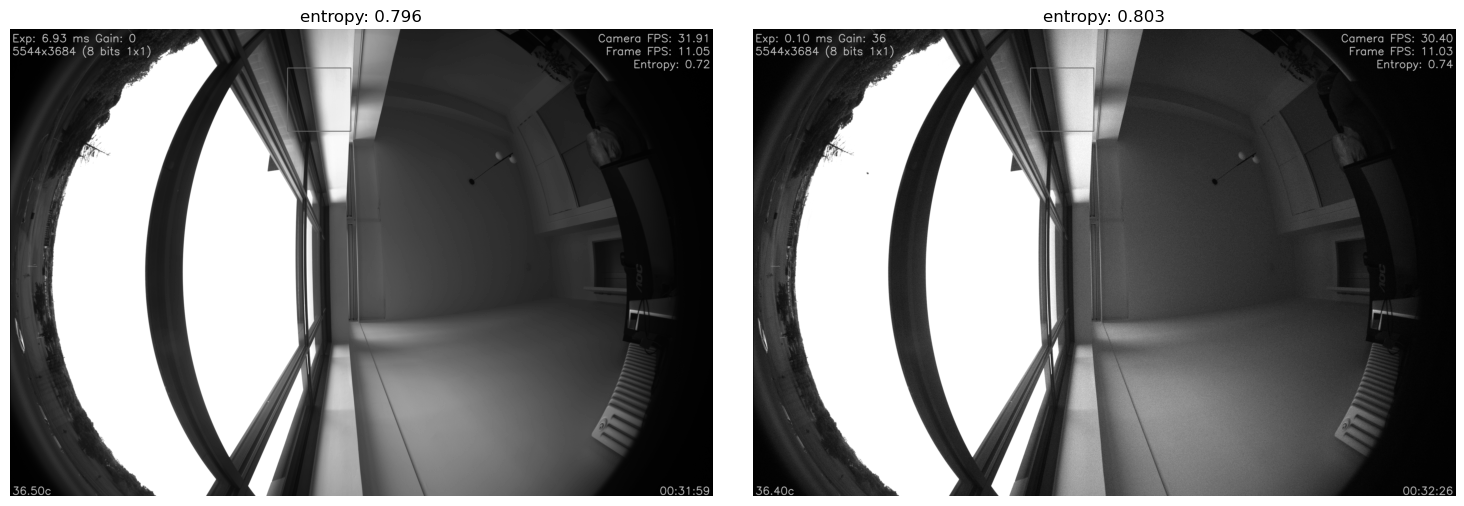

In [14]:
img = cv2.imread('images/no_gain.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('images/high_gain.png', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('entropy: ' + str(round(abs(calc_entropy(img)), 3)))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
plt.title('entropy: ' + str(round(calc_entropy(img2), 3)))
plt.axis('off')

plt.tight_layout()
plt.show()